# Neural machine translation with attention

https://www.tensorflow.org/tutorials/text/nmt_with_attention

## Requirements

In [1]:
import tensorflow as tf

import unicodedata
import re
import numpy as np
import os
import io
import time
import random
import json
import operator
from collections import defaultdict

import nltk

In [2]:
from google.colab import drive
drive.mount('/content/drive')

#!cp '/content/drive/My Drive/tesi/from_scratch/tensorflow/data/la-en.txt' la-en.txt

Mounted at /content/drive


## Dataset

In [3]:
#path_to_file = "la-en.txt"
path_to_file = 'drive/My Drive/tesi/from_scratch/tensorflow/data/la-en.txt'

In [4]:
path_to_file

'drive/My Drive/tesi/from_scratch/tensorflow/data/la-en.txt'

In [5]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip())

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,¿])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [6]:
#MAX_LENGTH = 50

#def filterPair(p):
#    return len(p[0].split(' ')) < MAX_LENGTH and \
#        len(p[1].split(' ')) < MAX_LENGTH


#def filterPairs(pairs):
#    return [pair for pair in pairs if filterPair(pair)]

In [7]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')

  pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]

  #word_pairs = filterPairs(pairs)

  return zip(*pairs)

In [8]:
def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)

  tensor = lang_tokenizer.texts_to_sequences(lang)

  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

  return tensor, lang_tokenizer

In [9]:
# BLEU score
# Translation quality metrics like BLEU
# are designed to use multiple references of a correct translation. 
# To take this into account during evaluation I combined pairs with an 
# identical source into one pair with one source and multiple targets
#
# dati due linguaggi di un rispettivo dataser, questa funzione crea un dizionario
# in cui come chiave ci sarà la frase in limgua latina e come valore ci sarà
# uyna lista con tutte le traduzioni di quella frase
def source_target_sents(lang1, lang2):
  source_to_target = {}
  for source, target in zip(lang1, lang2):
      if source in source_to_target:
          source_to_target[source].append(target)
      else:
          source_to_target[source] = [target]
      
  source_sents, target_sents = zip(*source_to_target.items())

  return source_sents, target_sents, source_to_target

In [10]:
def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  inp_lang, targ_lang, *other = create_dataset(path, num_examples)

  source_sents, target_sents, source_to_target = source_target_sents(inp_lang, targ_lang)

  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer, source_to_target

In [11]:
# Try experimenting with the size of that dataset
#num_examples = 50000
lines = io.open(path_to_file, encoding='UTF-8').read()
num_examples = len(lines)
input_tensor, target_tensor, inp_lang, targ_lang, source_to_target = load_dataset(path_to_file, num_examples)
print(len(input_tensor), len(target_tensor))

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

61939 61939


In [12]:
from sklearn.model_selection import train_test_split

random_state = 3

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2, random_state=random_state)
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.1, random_state=random_state)
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val), len(input_tensor_test), len(target_tensor_test))

44595 44595 4956 4956 12388 12388


In [13]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[5])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
37 ----> si
5905 ----> dixeris
6 ----> in
326 ----> corde
237 ----> tuo
1035 ----> plures
11 ----> sunt
625 ----> gentes
4772 ----> istae
27 ----> quam
50 ----> ego
220 ----> quomodo
5334 ----> potero
11190 ----> delere
536 ----> eas
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
428 ----> peter
6 ----> and
256 ----> john
52 ----> were
201 ----> going
67 ----> up
91 ----> into
5 ----> the
532 ----> temple
50 ----> at
5 ----> the
750 ----> hour
7 ----> of
784 ----> prayer
4 ----> ,
5 ----> the
2089 ----> ninth
750 ----> hour
3 ----> .
2 ----> <end>


## Hyperparameters

In [15]:
embedding_dim = 256
units = 512

TRAIN_BUFFER_SIZE = len(input_tensor_train)
VAL_BUFFER_SIZE = len(input_tensor_val)
TEST_BUFFER_SIZE = len(input_tensor_test)

TRAIN_BATCH_SIZE = 256
VAL_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512

train_steps_per_epoch = len(input_tensor_train)//TRAIN_BATCH_SIZE
val_steps_per_epoch = len(input_tensor_val)//VAL_BATCH_SIZE

vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(TRAIN_BUFFER_SIZE)
train_dataset = train_dataset.batch(TRAIN_BATCH_SIZE, drop_remainder=True)
val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(VAL_BATCH_SIZE, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(TEST_BUFFER_SIZE)
test_dataset = test_dataset.batch(TEST_BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch_train, example_target_batch_train = next(iter(train_dataset))
example_input_batch_train.shape, example_target_batch_train.shape

(TensorShape([256, 35]), TensorShape([256, 37]))

In [17]:
example_input_batch_val, example_target_batch_val = next(iter(val_dataset))
example_input_batch_val.shape, example_target_batch_val.shape

(TensorShape([512, 35]), TensorShape([512, 37]))

In [18]:
example_input_batch_test, example_target_batch_test = next(iter(test_dataset))
example_input_batch_test.shape, example_target_batch_test.shape

(TensorShape([512, 35]), TensorShape([512, 37]))

## Architecture

In [19]:
class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units):
    super(Encoder, self).__init__()
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.25,
                                   recurrent_dropout=0.25)

  def call(self, x):
    x = self.embedding(x)
    output, state = self.gru(x)
    return output, state

In [20]:
encoder = Encoder(vocab_inp_size, embedding_dim, units)

In [21]:
# sample input
#sample_hidden = encoder.initialize_hidden_state()
#sample_output, sample_hidden = encoder(example_input_batch)
#print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
#print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [23]:
#attention_layer = BahdanauAttention(10)
#attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

#print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
#print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

In [24]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units):
    super(Decoder, self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim, mask_zero=True)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   dropout=0.25,
                                   recurrent_dropout=0.25)
    #self.dropout = tf.keras.layers.Dropout(0.25)
    self.fc = tf.keras.layers.Dense(vocab_size)
    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, enc_output, training):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output)
    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)
    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))
    #output = self.dropout(output, training=training)
    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [25]:
decoder = Decoder(vocab_tar_size, embedding_dim, units)

In [26]:
#sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)

#print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

In [27]:
optimizer = tf.keras.optimizers.Adam()

# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)
  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

## Set checkpoints

In [28]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

In [29]:
@tf.function
def train_step(inp, targ):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp)
    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * TRAIN_BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=True)
      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [30]:
@tf.function
def valid_step(inp, targ):
  loss = 0

  enc_output, enc_hidden = encoder(inp)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * VAL_BATCH_SIZE, 1)

  # Teacher forcing - feeding the target as the next input
  for t in range(1, targ.shape[1]):
    # passing enc_output to the decoder
    predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output, training=False)
    loss += loss_function(targ[:, t], predictions)

    # using teacher forcing
    dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  return batch_loss

In [31]:
from tqdm.notebook import tqdm

epochs = 0
early_stop_after = 3
early_stop_counter = 0
minimum_val_loss = 10.0

model_loss_history = {'train_loss_history' : [], 'val_loss_history' : []}

total_time_start = time.time()

for epoch in range(100):
  start = time.time()

  #enc_hidden = encoder.initialize_hidden_state()
  total_train_loss = 0
  total_val_loss = 0

  # Training
  for (batch, (inp, targ)) in tqdm(enumerate(train_dataset.take(train_steps_per_epoch)), 
                                   desc='Training epoch {}'.format(epoch+1), 
                                   total=train_steps_per_epoch):
    train_batch_loss = train_step(inp, targ)
    total_train_loss += train_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Training Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   train_batch_loss.numpy()))
  
  # Validation
  for (batch, (inp, targ)) in tqdm(enumerate(val_dataset.take(val_steps_per_epoch)), 
                                   desc='Val epoch {}'.format(epoch+1), 
                                   total=val_steps_per_epoch):
    val_batch_loss = valid_step(inp, targ)
    total_val_loss += val_batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Validation Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   val_batch_loss.numpy()))

  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print("<---------------------------------------->")
  print('Epoch {} Training Loss {:.4f} Validation Loss {:.4f}'.format(epoch + 1,
                                      total_train_loss / train_steps_per_epoch,
                                      total_val_loss / val_steps_per_epoch))
  
  model_loss_history['train_loss_history'].append((total_train_loss / train_steps_per_epoch).numpy())
  model_loss_history['val_loss_history'].append((total_val_loss / val_steps_per_epoch).numpy())

  print('Time taken for the epoch {} sec\n'.format(time.time() - start))

  epochs += 1

  # Early Stop
  if (total_val_loss/val_steps_per_epoch) < minimum_val_loss:
    early_stop_counter = 0
    print('The best model is found, resetting early stop counter.')
    minimum_val_loss = total_val_loss/val_steps_per_epoch
  else:
    early_stop_counter += 1
    print('No improvements for {} epochs.'.format(early_stop_counter))
    if early_stop_counter >= early_stop_after:
      print('Early stop!')
      break

print('Total Time taken for the training {} sec\n'.format(time.time() - total_time_start))

Epoch 1 Batch 0 Training Loss 3.2757
Epoch 1 Batch 100 Training Loss 1.9754



Epoch 1 Batch 0 Validation Loss 1.8856

<---------------------------------------->
Epoch 1 Training Loss 2.0270 Validation Loss 1.8742
Time taken for the epoch 204.67329502105713 sec

The best model is found, resetting early stop counter.


Epoch 2 Batch 0 Training Loss 1.8235
Epoch 2 Batch 100 Training Loss 1.8060



Epoch 2 Batch 0 Validation Loss 1.8026

<---------------------------------------->
Epoch 2 Training Loss 1.7781 Validation Loss 1.7821
Time taken for the epoch 143.51352882385254 sec

The best model is found, resetting early stop counter.


Epoch 3 Batch 0 Training Loss 1.7181
Epoch 3 Batch 100 Training Loss 1.7357



Epoch 3 Batch 0 Validation Loss 1.7683

<---------------------------------------->
Epoch 3 Training Loss 1.6879 Validation Loss 1.7211
Time taken for the epoch 143.58175826072693 sec

The best model is found, resetting early stop counter.


Epoch 4 Batch 0 Training Loss 1.6807
Epoch 4 Batch 100 Training Loss 1.6216



Epoch 4 Batch 0 Validation Loss 1.6078

<---------------------------------------->
Epoch 4 Training Loss 1.6091 Validation Loss 1.6546
Time taken for the epoch 147.31024885177612 sec

The best model is found, resetting early stop counter.


Epoch 5 Batch 0 Training Loss 1.4327
Epoch 5 Batch 100 Training Loss 1.6120



Epoch 5 Batch 0 Validation Loss 1.6459

<---------------------------------------->
Epoch 5 Training Loss 1.5316 Validation Loss 1.6059
Time taken for the epoch 145.7546935081482 sec

The best model is found, resetting early stop counter.


Epoch 6 Batch 0 Training Loss 1.4926
Epoch 6 Batch 100 Training Loss 1.4739



Epoch 6 Batch 0 Validation Loss 1.5469

<---------------------------------------->
Epoch 6 Training Loss 1.4574 Validation Loss 1.5607
Time taken for the epoch 147.10399866104126 sec

The best model is found, resetting early stop counter.


Epoch 7 Batch 0 Training Loss 1.4828
Epoch 7 Batch 100 Training Loss 1.4149



Epoch 7 Batch 0 Validation Loss 1.5245

<---------------------------------------->
Epoch 7 Training Loss 1.3917 Validation Loss 1.5224
Time taken for the epoch 147.67832970619202 sec

The best model is found, resetting early stop counter.


Epoch 8 Batch 0 Training Loss 1.3235
Epoch 8 Batch 100 Training Loss 1.3255



Epoch 8 Batch 0 Validation Loss 1.5165

<---------------------------------------->
Epoch 8 Training Loss 1.3337 Validation Loss 1.5042
Time taken for the epoch 149.321448802948 sec

The best model is found, resetting early stop counter.


Epoch 9 Batch 0 Training Loss 1.2983
Epoch 9 Batch 100 Training Loss 1.2683



Epoch 9 Batch 0 Validation Loss 1.4319

<---------------------------------------->
Epoch 9 Training Loss 1.2816 Validation Loss 1.4768
Time taken for the epoch 148.4045672416687 sec

The best model is found, resetting early stop counter.


Epoch 10 Batch 0 Training Loss 1.1524
Epoch 10 Batch 100 Training Loss 1.2593



Epoch 10 Batch 0 Validation Loss 1.4864

<---------------------------------------->
Epoch 10 Training Loss 1.2326 Validation Loss 1.4791
Time taken for the epoch 148.93119835853577 sec

No improvements for 1 epochs.


Epoch 11 Batch 0 Training Loss 1.1494
Epoch 11 Batch 100 Training Loss 1.2104



Epoch 11 Batch 0 Validation Loss 1.4521

<---------------------------------------->
Epoch 11 Training Loss 1.1860 Validation Loss 1.4614
Time taken for the epoch 146.94199347496033 sec

The best model is found, resetting early stop counter.


Epoch 12 Batch 0 Training Loss 1.1050
Epoch 12 Batch 100 Training Loss 1.1550



Epoch 12 Batch 0 Validation Loss 1.4395

<---------------------------------------->
Epoch 12 Training Loss 1.1405 Validation Loss 1.4467
Time taken for the epoch 147.7402470111847 sec

The best model is found, resetting early stop counter.


Epoch 13 Batch 0 Training Loss 1.1467
Epoch 13 Batch 100 Training Loss 1.1131



Epoch 13 Batch 0 Validation Loss 1.4662

<---------------------------------------->
Epoch 13 Training Loss 1.0933 Validation Loss 1.4436
Time taken for the epoch 147.59913563728333 sec

The best model is found, resetting early stop counter.


Epoch 14 Batch 0 Training Loss 0.9921
Epoch 14 Batch 100 Training Loss 1.0629



Epoch 14 Batch 0 Validation Loss 1.4229

<---------------------------------------->
Epoch 14 Training Loss 1.0466 Validation Loss 1.4401
Time taken for the epoch 147.86838030815125 sec

The best model is found, resetting early stop counter.


Epoch 15 Batch 0 Training Loss 0.9875
Epoch 15 Batch 100 Training Loss 0.9761



Epoch 15 Batch 0 Validation Loss 1.3307

<---------------------------------------->
Epoch 15 Training Loss 0.9989 Validation Loss 1.4282
Time taken for the epoch 147.4281976222992 sec

The best model is found, resetting early stop counter.


Epoch 16 Batch 0 Training Loss 0.8837
Epoch 16 Batch 100 Training Loss 0.9850



Epoch 16 Batch 0 Validation Loss 1.5148

<---------------------------------------->
Epoch 16 Training Loss 0.9518 Validation Loss 1.4391
Time taken for the epoch 149.8698766231537 sec

No improvements for 1 epochs.


Epoch 17 Batch 0 Training Loss 0.9026
Epoch 17 Batch 100 Training Loss 0.9318



Epoch 17 Batch 0 Validation Loss 1.3820

<---------------------------------------->
Epoch 17 Training Loss 0.9060 Validation Loss 1.4283
Time taken for the epoch 148.00555229187012 sec

No improvements for 2 epochs.


Epoch 18 Batch 0 Training Loss 0.8263
Epoch 18 Batch 100 Training Loss 0.9207



Epoch 18 Batch 0 Validation Loss 1.4512

<---------------------------------------->
Epoch 18 Training Loss 0.8616 Validation Loss 1.4416
Time taken for the epoch 149.7928650379181 sec

No improvements for 3 epochs.
Early stop!
Total Time taken for the training 2711.536523580551 sec



In [32]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_model_history(model_history):
  
  rows, cols = 1, 2
  fig, axs = plt.subplots(rows, cols, figsize=(15, 5))
    
  # summarize history for train_loss
  axs[0].plot(range(1, len(model_history['train_loss_history'])+1), 
              model_history['train_loss_history'], 
              color = 'blue')
  axs[0].scatter(range(1, len(model_history['train_loss_history'])+1), 
                 model_history['train_loss_history'], 
                 color = 'blue')
  axs[0].set_title('Train Loss')
  axs[0].set_ylabel('Loss')
  axs[0].set_xlabel('Epochs')
  axs[0].set_xticks(np.arange(epochs+1))
  axs[0].legend(['train'], loc='best')



  # summarize history for val_loss
  axs[1].plot(range(1, len(model_history['val_loss_history'])+1), 
              model_history['val_loss_history'], 
              color = 'red')
  axs[1].scatter(range(1, len(model_history['val_loss_history'])+1), 
                 model_history['val_loss_history'], 
                 color = 'red')
  axs[1].set_title('Val Loss')
  axs[1].set_ylabel('Loss')
  axs[1].set_xlabel('Epochs')
  axs[1].set_xticks(np.arange(epochs+1))
  axs[1].legend(['val'], loc='best')

  plt.show()

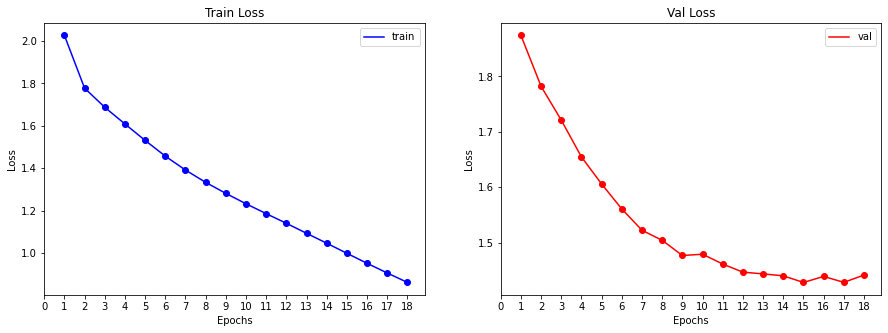

In [33]:
plot_model_history(model_loss_history)

## Translate

In [34]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))
  sentence = preprocess_sentence(sentence)
  inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')

  inputs = tf.convert_to_tensor(inputs)
  result = ''
  enc_out, enc_hidden = encoder(inputs)
  dec_hidden = enc_hidden
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden,
                                                         enc_out,
                                                         training=False)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '
    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot
    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [35]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [36]:
def translate(sentence, with_plot=True):
  result, sentence, attention_plot = evaluate(sentence)
  if(with_plot):
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))
  
  return result, sentence, attention_plot

## Restore checkpoint

In [37]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [38]:
model = checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [39]:
model

## Metrics

### Sentence BLEU score

In [40]:
#trasforma il tensore in frase
def tensor2sentence(lang, tensor):
  sentence = ""
  for t in tensor:
    if t!=0:
      sentence += lang.index_word[t] + " "
  return sentence

In [41]:
# questa funzione dato un insieme in input ed un dizionario,
# mi trasforma tutti i tensori di tale insieme in un insieme
# di frasi corrispondenti
def tensor2set(tensor_set, lang):
  list = []
  for tensor in tensor_set:
    sentence = tensor2sentence(lang, tensor)
    list.append(sentence)
  
  return list

In [42]:
source_sents_test = tensor2set(input_tensor_test, inp_lang)

In [43]:
# poichè nel dataset ci sono molte frasi che hanno diverse traduzioni,
# questa funzione trova tutte le traduzioni di una determinata frase
# nel dizionario passato come parametro
def multiple_target(sentence, dict):
  targets = []
  for key, value in dict.items():
    if key == sentence and len(value) > 1:
      targets += (value)
  return targets

In [44]:
# questa funzione sceglie casualmente una frase dal sents_set,
# assicurandosi che tale frase abbia almeno 4 traduzioni diverse
# nel dizionario source_target_sents
def sent_random_choice(sents_set, source_to_target):

  full_sent = random.choice(source_sents_test).strip()
  targets = multiple_target(full_sent, source_to_target)

  if len(targets) > 3:
    print(full_sent)
    print(len(targets))
    return full_sent, targets
  else:
    return sent_random_choice(sents_set, source_to_target)

In [45]:
def clean_sentence(sentence):
  sentence = sentence.lstrip("<start>")
  sentence = sentence.rstrip("<end>")
  sentence = sentence.strip()
  sentence = re.sub(r"[^a-zA-Z]+", " ", sentence)

  return sentence

In [46]:
full_sent, targets = sent_random_choice(source_sents_test, source_to_target)

<start> et factum est verbum domini ad me dicens <end>
42


In [47]:
short_sent = clean_sentence(full_sent)

Input: <start> et factum est verbum domini ad me dicens <end>
Predicted translation: the word of yahweh came to me , saying , <end> 


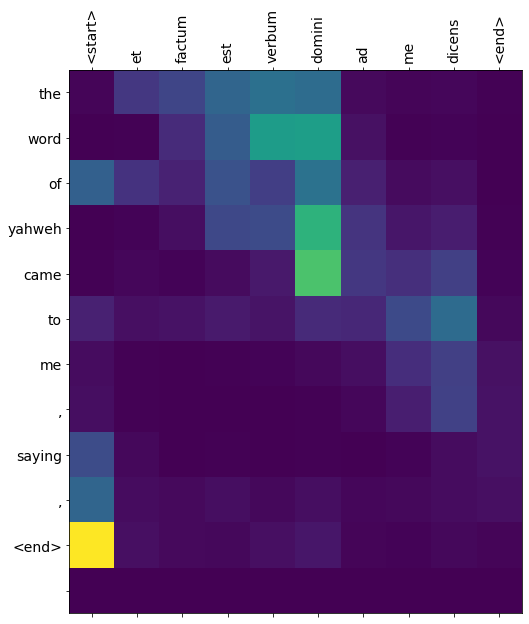

In [48]:
translation, sentence, attention_plot = translate(short_sent)

In [49]:
def clean_corpus_references(targets, split=False):
  references = []
  for t in targets:
    t = clean_sentence(t)
    if split == True:
      references.append(t.split())
    else:
      references.append(t)

  return references

In [50]:
references = clean_corpus_references(targets, split=True)

In [51]:
def clean_translation(translation):
  translation = translation.rstrip("<end>")
  translation = re.sub(r"[^a-zA-Z]+", " ", translation)
  translation = translation.strip()

  return translation

In [52]:
translation = clean_translation(translation)

In [53]:
hypothesis = list(translation.split())

While matching sentences you can choose the number of words you want the model to match at once.
You can also choose for words to be matched one at a time (1-gram), or to match words in pairs (2-gram) or triplets (3-grams)...


BLEU non è mai stato creato pensando al confronto del livello di frase, ecco una bella discussione: https://github.com/nltk/nltk/issues/1838 Molto probabilmente, vedrai l'avviso quando hai frasi molto brevi

In [54]:
from nltk.translate import bleu
from nltk.translate.bleu_score import sentence_bleu

print('Individual 1-gram: %f' % sentence_bleu(references, hypothesis, weights=(1, 0, 0, 0)))
print('Individual 2-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 1, 0, 0)))
print('Individual 3-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 0, 1, 0)))
print('Individual 4-gram: %f' % sentence_bleu(references, hypothesis, weights=(0, 0, 0, 1)))

Individual 1-gram: 0.888889
Individual 2-gram: 0.875000
Individual 3-gram: 0.857143
Individual 4-gram: 0.833333


By default the sentence_bleu() function calculates the cumulative 4-gram BLEU score, also called BLEU-4. The weights for BLEU-4 are as follows :

The default BLEU calculates a score for up to 4-grams using uniform weights (this is called BLEU-4), where each weight is 1/4.

In [55]:
sentence_score = sentence_bleu(references, hypothesis, weights=(0.25, 0.25, 0.25, 0.25))
print('BLEU-4: %f' % sentence_score)

BLEU-4: 0.863340


BLEU score problems:

* It doesn’t consider meaning
* It doesn’t directly consider sentence structure
* It doesn’t handle morphologically rich languages well
* It doesn’t map well to human judgements

You can use the smoothing functions in https://github.com/alvations/nltk/blob/develop/nltk/translate/bleu_score.py#L425 to overcome short sentences.



This is an implementation of the smoothing techniques for segment-level BLEU scores that was presented in Boxing Chen and Collin Cherry (2014) A Systematic Comparison of Smoothing Techniques for Sentence-Level BLEU. In WMT14.
http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf

In [56]:
from nltk.translate.bleu_score import SmoothingFunction

smoothie = SmoothingFunction().method4
smoothie_score = bleu(references, hypothesis, smoothing_function=smoothie)
print('SMOOTHIE SCORE: %f' % smoothie_score)

SMOOTHIE SCORE: 0.863340


### Corpus BLEU score

http://www.nltk.org/api/nltk.translate.html#nltk.translate.bleu_score.corpus_bleu

Instead of averaging the sentence level BLEU scores (i.e. marco-average precision), the original BLEU metric (Papineni et al. 2002) accounts for the micro-average precision (i.e. summing the numerators and denominators for each hypothesis-reference(s) pairs before the division).

In [57]:
def prepare_corpus(source_sents_test, source_target_sents):
  list_of_references = []
  hypothesis = []
  for sent in source_sents_test:
    targets = multiple_target(sent.strip(), source_target_sents)
    if len(targets) > 3:
      full_sent = clean_sentence(sent)
      translation, sentence, attention_plot = translate(full_sent, 
                                                        with_plot=False)
      
      translation = translation.rstrip("<end>").strip()
      translation = re.sub(r"[^a-zA-Z]+", " ", translation)
      targets = clean_corpus_references(targets, split=True)
      list_of_references.append(targets)
      hypothesis.append(translation.split())
  
  return hypothesis, list_of_references

In [58]:
hypothesis, list_of_references = prepare_corpus(source_sents_test, source_to_target)

In [59]:
from nltk.translate.bleu_score import corpus_bleu

corpus_score = corpus_bleu(list_of_references, hypothesis)
print('CORPUS BLEU SCORE: %f' % corpus_score)

CORPUS BLEU SCORE: 0.329959


## Attention Weights

Input: <start> et factum est verbum domini ad me dicens <end>
Predicted translation: the word of yahweh came to me , saying , <end> 


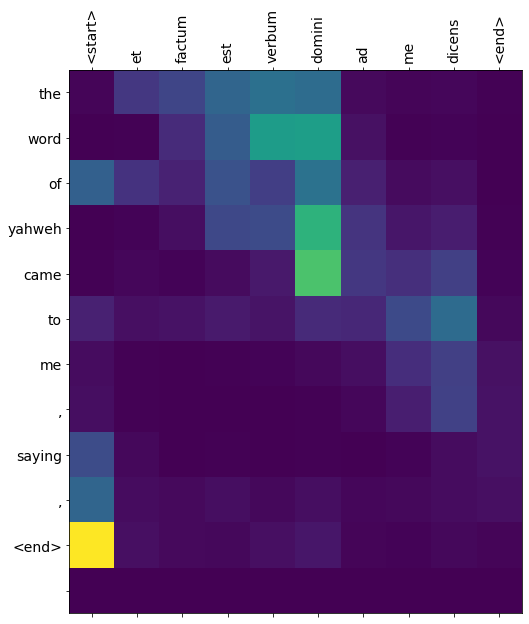

In [60]:
sentence = full_sent.lstrip("<start>").rstrip("<end>").strip()
outputs, inputs, attention_plot = translate(sentence)

In [61]:
column_index2token = defaultdict(str)

for i, token in enumerate(inputs.split()):
  column_index2token[i] = token

print(column_index2token)

row_index2token = defaultdict(str)

for i, token in enumerate(outputs.split()):
  row_index2token[i] = token

print(row_index2token)

defaultdict(<class 'str'>, {0: '<start>', 1: 'et', 2: 'factum', 3: 'est', 4: 'verbum', 5: 'domini', 6: 'ad', 7: 'me', 8: 'dicens', 9: '<end>'})
defaultdict(<class 'str'>, {0: 'the', 1: 'word', 2: 'of', 3: 'yahweh', 4: 'came', 5: 'to', 6: 'me', 7: ',', 8: 'saying', 9: ',', 10: '<end>'})


In [62]:
def translate2attn(result, sentence, attention_plot):
  translation_weights = {}
  for i, token in enumerate(result.split()):
    translation_weights[token] = {}
    for j, tkn in enumerate(sentence.split()):
      translation_weights[token][tkn] = attention_plot[i][j]

  return translation_weights

In [63]:
def attn2json(translation_weights):
  with open('attention_weights.json', 'w') as fp:
    json.dump(translation_weights, fp)

In [64]:
def translation_prediction(translation_weights):
  translation_prediction = {}
  for key, value in translation_weights.items():
    maximum = max(value, key=value.get)
    translation_prediction[key] = maximum

  return translation_prediction

In [65]:
#print("inputs: {}".format(inputs))
#print("outputs: {}".format(outputs))
#print("attention_plot: {}".format(attention_plot))

translation_weights = translate2attn(outputs, inputs, attention_plot)

translation_prediction(translation_weights)

#attn2json(translation_weights)

{',': '<start>',
 '<end>': '<start>',
 'came': 'domini',
 'me': 'dicens',
 'of': 'domini',
 'saying': '<start>',
 'the': 'verbum',
 'to': 'dicens',
 'word': 'domini',
 'yahweh': 'domini'}

## Custom predictions

Input: <start> hodie si frigus valde serenum est . <end>
Predicted translation: if it is more expensive than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful than beautiful 


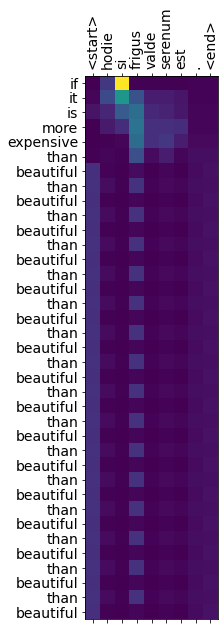

In [66]:
sentence = 'hodie si frigus valde serenum est .'
outputs, inputs, attention_plot = translate(sentence)

Input: <start> tom cum romam venit tu quoque ? <end>
Predicted translation: tom came to do ? <end> 


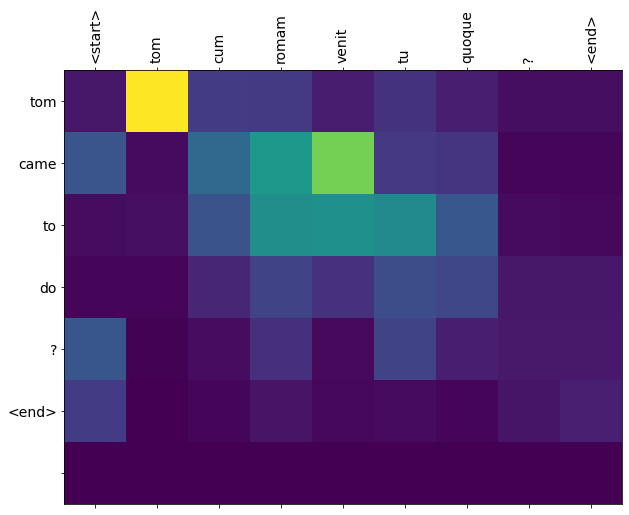

In [67]:
sentence = 'tom cum romam venit tu quoque ?'
outputs, inputs, attention_plot = translate(sentence)

Input: <start> et factus est sermo domini ad me dicens <end>
Predicted translation: the word of yahweh came to me , saying , <end> 


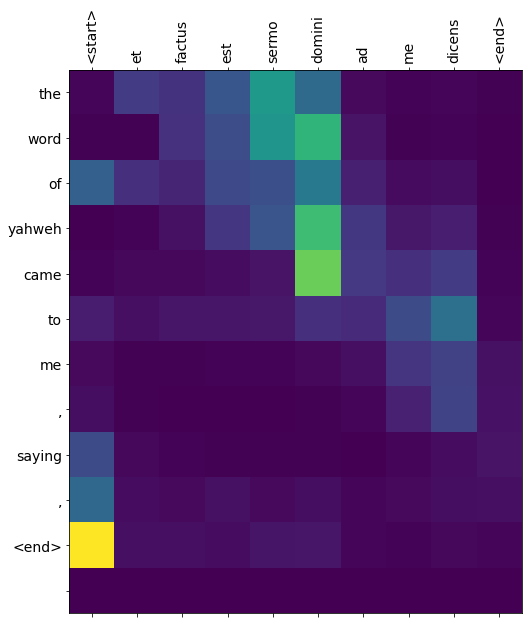

In [68]:
sentence = 'et factus est sermo domini ad me dicens'
translation, inputs, attention_plot = translate(sentence)

## StanfordNERTagger

In [69]:
!pip install nltk

In [70]:
!wget 'https://nlp.stanford.edu/software/stanford-ner-4.2.0.zip'
!unzip stanford-ner-4.2.0.zip

--2021-02-12 10:46:33--  https://nlp.stanford.edu/software/stanford-ner-4.2.0.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 180437064 (172M) [application/zip]
Saving to: ‘stanford-ner-4.2.0.zip’

stanford-ner-4.2.0. 100%[===================>] 172.08M  34.1MB/s    in 6.2s    

2021-02-12 10:46:40 (27.6 MB/s) - ‘stanford-ner-4.2.0.zip’ saved [180437064/180437064]

Archive:  stanford-ner-4.2.0.zip
   creating: stanford-ner-2020-11-17/
   creating: stanford-ner-2020-11-17/lib/
  inflating: stanford-ner-2020-11-17/lib/jollyday-0.4.9.jar  
  inflating: stanford-ner-2020-11-17/lib/stanford-ner-resources.jar  
  inflating: stanford-ner-2020-11-17/lib/joda-time.jar  
  inflating: stanford-ner-2020-11-17/stanford-ner-4.2.0.jar  
  inflating: stanford-ner-2020-11-17/NERDemo.java  
  inflating: stanford-ner-2020-11-17/LICENSE.txt  
  inflati

In [71]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [72]:
from nltk.tag.stanford import StanfordNERTagger
from nltk.tokenize import word_tokenize

jar = "stanford-ner-2020-11-17/stanford-ner-4.2.0.jar"
model = "stanford-ner-2020-11-17/classifiers/" 
st_3class = StanfordNERTagger(model + "english.all.3class.distsim.crf.ser.gz", jar, encoding='utf8')
st_4class = StanfordNERTagger(model + "english.conll.4class.distsim.crf.ser.gz", jar, encoding='utf8')
st_7class = StanfordNERTagger(model + "english.muc.7class.distsim.crf.ser.gz", jar, encoding='utf8')


/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/nltk/tag/stanford.py:183: DeprecationWarning: 
The StanfordTokenizer will be deprecated in version 3.2.5.
Please use nltk.tag.corenlp.CoreNLPPOSTagger or nltk.tag.corenlp.CoreNLPNERTagger instead.
  super(StanfordNERTagger, self).__init__(*args, **kwargs)


In [73]:
#translation = clean_translation(translation)

In [74]:
#translation

In [75]:
text = 'president barack hussein obama was born in honolulu on august 4, 1961.'
tokenized_text = word_tokenize(text)

In [76]:
classified_text = st_7class.tag(tokenized_text)
print(classified_text)

[('president', 'O'), ('barack', 'PERSON'), ('hussein', 'PERSON'), ('obama', 'PERSON'), ('was', 'O'), ('born', 'O'), ('in', 'O'), ('honolulu', 'LOCATION'), ('on', 'O'), ('august', 'DATE'), ('4', 'DATE'), (',', 'DATE'), ('1961', 'DATE'), ('.', 'O')]
